## Import required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
# Lasso not completly necessary!! We will see this
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from sklearn.tree import DecisionTreeRegressor, export_graphviz
# create a dot_file which stores the tree structure-NOt running in my system
from IPython.display import Image  
import pydotplus
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Define all the helper classes and function. 
#### The accuracy metrics of each model type is stored and then compared with each other to find the optimal Model

In [ ]:
#Defining class for each Model Type 

#container to fit the Regression  Model
class MultipleRegression():
    def __init__(self):
        self.metrics={}
        self.multiplereg=LinearRegression()
    def createRegModel(self):
        self.multiplereg.fit(X_train,Y_train)
        tScore=self.multiplereg.score(X_train,Y_train)
        vScore=self.multiplereg.score(X_valid,Y_valid)
        print("Training data Score is",tScore)
        print("Validation data Score is",vScore)
        pred=self.multiplereg.predict(X_valid) #predicting values of y for all the xtest rows
        mse=mean_squared_error(Y_valid,pred)
        rmse=round(mse**0.5,2)
        print("RMSE in case of Multiple regression Model:",rmse)
        print("MSE in case of Multiple regression Model:",mse)
        self.metrics['modelName']='Basic Multiple Regression'
        self.metrics['trainScore']=tScore
        self.metrics['testScore']=vScore
        self.metrics['RMSE']=rmse
        self.metrics['MSE']=round(mse,2)
        self.metrics['className']='MultipleRegression'
        #self.checkSignificance()
        modelList.append(self.metrics)
        print(".........................Coefficients are....................")
        
    def getModel(self):
        return self.multiplereg
    def getMetrics(self):
        return self.metrics
    
    def checkSignificance(self):
        x = sm.add_constant(X_train)
        lm = sm.OLS(Y_train,x).fit()
        print(lm.summary())
        


In [ ]:
#container to fit the Lasso Regression  Model
class LassoRegression():
    def __init__(self):
        self.metrics={}
        self.lassoreg=LassoCV(alphas = None,cv =10, max_iter = 10000)
    def createLassoReg(self):
        print("Hyper Parameter Tuning for choosing the optimal value of alpha")
        self.lassoreg = LassoCV(alphas = None,cv =10, max_iter = 10000)
        self.lassoreg.fit(X_train,Y_train)
        alpha = self.lassoreg.alpha_
        print("Alpha after fitting LassoCV",alpha)
        self.lassoreg = Lasso(alpha)
        self.lassoreg.fit(X_train,Y_train)
        tScore=self.lassoreg.score(X_train,Y_train)
        vScore=self.lassoreg.score(X_valid,Y_valid)
        pred=self.lassoreg.predict(X_valid) #predicting values of y for all the xtest rows
        mse=mean_squared_error(Y_valid,pred)
        rmse=round(mse**0.5,2)
        print("Training data Score  of LassoCV is",tScore)
        print("Validation data Score of LassoCV is",vScore)
        print("RMSE in case of Lasso regression Model:",rmse)
        print("MSE in case of Lasso regression Model:",round(mse,2))
        
        self.metrics['modelName']='Lasso Regression Model'
        self.metrics['className']='LassoRegression'
        self.metrics['trainScore']=tScore
        self.metrics['testScore']=vScore
        self.metrics['RMSE']=rmse
        self.metrics['MSE']=round(mse,2)
        modelList.append(self.metrics)
        
    def getModel(self):
        return self.lassoreg
    
    def getMetrics(self):
        return self.metrics


In [ ]:
#container to fit the Regressor Model
class RegressorTree:
    def __init__(self):
        self.metrics={}
        self.regressorTree=DecisionTreeRegressor(random_state = 2) 
    def createRegressorTree(self):
        self.regressorTree.fit(X_train, Y_train)
        print("Pruning the Tree starts") 
        #best_params=self.grid_search(self.regressorTree)
        best_params={'max_depth': 9, 'min_samples_leaf': 10}
        print("Optimal hyperparameters after GridSearchCV",best_params)
        print("Pruning ends")
        self.regressorTree = DecisionTreeRegressor(max_depth=best_params['max_depth'],
                                              min_samples_leaf =best_params['min_samples_leaf'])
        self.regressorTree.fit(X_train,Y_train)
        tScore = self.regressorTree.score(X_train, Y_train)
        vScore = self.regressorTree.score(X_train, Y_train)
        Y_pred = self.regressorTree.predict(X_valid) 
        # The mean squared error
        mse=mean_squared_error(Y_valid,Y_pred)
        rmse=round(mse**0.5,2)
        print("Training data Score  of Regression Tree  Model is",tScore)
        print("Validation data Score of Regression Tree   Model is",vScore)
        print("RMSE in case of Regression Tree  Model:",rmse)
        print("RMSE in case of Regression Tree  Model:",round(mse,2))
        self.metrics['modelName']='Regression Tree Model'
        self.metrics['className']='RegressorTree'
        self.metrics['trainScore']=tScore
        self.metrics['testScore']=vScore
        self.metrics['RMSE']=rmse
        self.metrics['MSE']=round(mse,2)
        modelList.append(self.metrics)
        #plot the tree
        #self.plotTree()
        #plot featureImportance
        self.plotfeatureImp()
        
    def grid_search(self):
        #Grid Search for following params to improve accuracy and reduce overfitting
        grid_param = {
            'max_depth' : range(3,10,1),
            'min_samples_leaf' : range(10,40,2)}
        grid_search = GridSearchCV(estimator=self.regressorTree,
                         param_grid=grid_param,verbose=2,
                         cv=10)
        grid_search.fit(X_train,Y_train)
        best_params=grid_search.best_params_
        return best_params
    
    def plotfeatureImp(self):
        #plot the featureImporatnce of each predictor sorted by the largest importance value
        feature_cols = X_train.columns
        feat_importance = self.regressorTree.tree_.compute_feature_importances(normalize=False)
        feat_imp_dict = dict(zip(feature_cols,self.regressorTree.feature_importances_))
        feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
        newdf=feat_imp.sort_values(by=0, ascending=False)
        print("Feature Importance as per the Regression Tree")
        print(newdf.head(15))        
        
    def plotTree(self):
        dot_data = export_graphviz(self.regressorTree,feature_names = list(X_train.columns),rounded = True,filled = True)
        graph = pydotplus.graph_from_dot_data(dot_data)  
        Image(graph.create_png())
        
    def getModel(self):
        return self.regressorTree
    
    def getMetrics(self):
        return self.metrics

  

In [ ]:
#Container to fit RandomForest Regression
class RandomForestReg():
    def __init__(self):
        self.metrics={}
        self.rfregressor=RandomForestRegressor()
    def createRFForest(self):
        print("Hyper Parameter Tuning for choosing the optimal value of alpha")
        #self.rfregressor=
        self.rfregressor.fit(X_train,Y_train)
        #best_params=self.grid_searchforRF()
        best_params = {
          "n_estimators" : 100,
          'min_samples_leaf' : 30,
          'min_samples_split': 70
           }
        print("optimal params for RF",best_params)
        print("HyperParameter tuning for RF ends")
        self.rfregressor = RandomForestRegressor(min_samples_leaf = best_params['min_samples_leaf']
                                     ,min_samples_split= best_params['min_samples_split'],
                                     n_estimators =best_params['n_estimators'])
        self.rfregressor.fit(X_train,Y_train)
        tScore=self.rfregressor.score(X_train,Y_train)
        vScore=self.rfregressor.score(X_valid,Y_valid)
        pred=self.rfregressor.predict(X_valid) #predicting values of y for all the xtest rows
        mse=mean_squared_error(Y_valid,pred)
        rmse=round(mse**0.5,2)
        print("Training data Score  of RF regressor is",tScore)
        print("Validation data Score of RF regressor is",vScore)
        print("RMSE in case of RF Regression Model:",rmse)
        print("MSE in case of RF Regression Model:",round(mse,2))
        
        self.metrics['modelName']='Random Forest Regression Model'
        self.metrics['className']='RandomForestRegressor'
        self.metrics['trainScore']=tScore
        self.metrics['testScore']=vScore
        self.metrics['RMSE']=rmse
        self.metrics['MSE']=round(mse,2)
        modelList.append(self.metrics)
        
    def getModel(self):
        return self.rfregressor
    
    def getMetrics(self):
        return self.metrics
    
    
    def grid_searchforRF(self):
        #Grid search for following params to reduce the model overfitting
        grid_param = {
          "n_estimators" : [90,100,115],
          'min_samples_leaf' : [10,20,30,40,50],
          'min_samples_split': [40,50,60,70,80]
           }
        grid_search = GridSearchCV(estimator=self.rfregressor,param_grid=grid_param,cv=5,verbose = 2)
        grid_search.fit(X_train,Y_train)
        best_params = grid_search.best_params_
        return best_params

In [ ]:
#Container to store accuracy metrics of all the Models for all the three clusters
class Model():
    def __init__(self):
        self.cluster0=None
        self.cluster1=None
        self.cluster2=None

In [ ]:

#Function to find the optimal model having least RMSE values
metricsList=[]
def findbestModel(clusterNo,model,multipleReg,treeReg,rfReg,lassoReg):
    print(" Finding best Model")
   
    sortedList = sorted(modelList, key=lambda item: item.get("RMSE"))[0]
    className=sortedList.get('className')
    fileName="model_cluster"+str(clusterNo)+".sav"
    if clusterNo==0:
        model.cluster0=pd.DataFrame(modelList)
    elif clusterNo ==1:
        model.cluster1=pd.DataFrame(modelList)
    else:
        model.cluster2=pd.DataFrame(modelList)

    if className=="MultipleRegression":
        pickle.dump(multipleReg.getModel(), open(fileName, 'wb'))
    elif className =="RegressorTree":
        pickle.dump(treeReg.getModel(), open(fileName, 'wb'))
    elif className =="RandomForestRegressor":
        pickle.dump(rfReg.getModel(), open(fileName, 'wb'))
    else:
        pickle.dump(lassoReg.getModel(), open(fileName, 'wb'))
        
        
    print("Best Model for cluster - "+str(clusterNo) +" is",className)
    

#Train all the Models one by one 
def createModels(clusterNo,model):
    treeReg=RegressorTree()
    lassoReg=LassoRegression()
    multipleReg=MultipleRegression()
    rfReg=RandomForestReg()
    space=' '
    print("...........................Multiple Regression Model started.......................")
    multipleReg.createRegModel()
    print("...........................Multiple Regression Model ended.......................")
    print(space*25)
    print(space*25)
    print("...........................Regression  Tree Model start .......................")
    treeReg.createRegressorTree()
    print("...........................Regression  Tree Model end .......................")
    print(space*25)
    print(space*25)
    print("...........................Random Forest Model start .......................")
    rfReg.createRFForest()
    print("...........................Random Forest Model end.......................")
    print(space*25)
    print(space*25)
    print("...........................Lasso Regression Model start .......................")
    lassoReg.createLassoReg()
    print("...........................Lasso Regression Model start .......................")
    findbestModel(clusterNo,model,multipleReg,treeReg,rfReg,lassoReg)
    



### Train model for each cluster 

In [ ]:
model=Model()
for  clusterNo in range(0,3):
    modelList=[]
    df=pd.read_csv("Cluster_"+str(clusterNo)+".csv",index_col=0)
    use_sample = False
    sample_fraction = 0.01
    if use_sample:
        df = df.sample(frac=sample_fraction).copy()
    df.reset_index(drop=True, inplace=True)
    Y=df['Purchase']
    X=df.drop(['Purchase','clusterNo'],axis=1)
    #Create dummy columns
    for col in ['Gender','Marital_Status','City_Category','Occupation','Product_Category_1']:
    X=pd.get_dummies(X, columns=[col], prefix=[col], drop_first=True)
    print("Shape of X is ",X.shape)
    # Divide into train and valid dataset 
    X_train,X_valid = train_test_split(X, test_size=0.2, random_state=42, shuffle=True)
    Y_train,Y_valid = train_test_split(Y, test_size=0.2, random_state=42, shuffle=True)
    createModels(clusterNo,model)

    

Shape of X is  (94750, 45)
...........................Multiple Regression Model started.......................
Training data Score is 0.6833937410364411
Validation data Score is 0.6828909235916903
RMSE in case of Multiple regression Model: 2748.72
MSE in case of Multiple regression Model: 7555476.691163134
.........................Coefficients are....................
...........................Multiple Regression Model ended.......................
                         
                         
...........................Regression  Tree Model start .......................
Pruning the Tree starts
Optimal hyperparameters after GridSearchCV {'max_depth': 9, 'min_samples_leaf': 10}
Pruning ends
Training data Score  of Regression Tree  Model is 0.6446103776183943
Validation data Score of Regression Tree   Model is 0.6446103776183943
RMSE in case of Regression Tree  Model: 2922.53
RMSE in case of Regression Tree  Model: 8541187.61
Feature Importance as per the Regression Tree
          

#### Create Multi Layer perceptron Model having 2 hidden layers and RELU as the activation function 

In [2]:
#Define the Neural Network Architecture
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(45, 20),
      nn.ReLU(),
      nn.Linear(20, 15),
      nn.ReLU(),
      nn.Linear(15, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [ ]:

#Function to train the Neural Network for n epochs with back propagation 
def train(model, train_loader, optimizer, epoch,loss_function):
    #model.train(); # It is specially required when Dropout and Batch Normalization is implemented.
    total_loss=0
    # Iterate through dataset
    for data, target in train_loader:
        target = target.unsqueeze(1)
        
        # Zero grad
        optimizer.zero_grad()
        output = model(data)
        loss = (loss_function(output, target))

        # Backward pass
        loss.backward()
        total_loss += loss.item()
        
        # Update
        optimizer.step()

    # Print average loss
    avgloss_epoch=total_loss / len(train_loader.dataset)
    if(epoch%2==0):
      print("Train Epoch: {}\t Loss: {:.6f}".format(epoch, avgloss_epoch))
    return avgloss_epoch

In [ ]:
#Function to test the Neural Network  performance on validation data
def test(model, test_loader,epoch,loss_function):
    model.eval() #It is specially required when Dropout and Batch Normalization is implemented.
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = target.unsqueeze(1)
            
            output = model(data)
            test_loss +=(loss_function(output, target)).item()

    test_loss /= len(test_loader.dataset)
    if(epoch%2==0):
      print('\nTest set: Average loss: {:.4f}\n'.format(
        test_loss))
    return test_loss

In [ ]:
### plot the loss value sof Training and Validation data for each epoch
def plotLoss(training_loss,validation_loss,epochs):
  plt.figure()
  plt.plot(range(1,epochs),training_loss,color='b',label="Training")
  plt.plot(range(1,epochs),validation_loss,color='g',label="Validation")
  plt.legend(loc="upper right")
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()


In [3]:
#Convert Numpyarrays to Tensor and then use DataLoader to create different batches of training and validation data.
def preprocess(df,clusterNo,requireLoader):
    Y=df['Purchase']
    X=df.drop(['Purchase','clusterNo'],axis=1)
    for col in ['Gender','Marital_Status','City_Category','Occupation','Product_Category_1']:
        X=pd.get_dummies(X, columns=[col], prefix=[col], drop_first=True)
    # Divide into train and valid dataset 
    X_train, X_valid = train_test_split(X.values, test_size=0.2, random_state=42, shuffle=True)
    Y_train, Y_valid = train_test_split(Y.values, test_size=0.2, random_state=42, shuffle=True)
    X_train=torch.FloatTensor(X_train)
    X_valid=torch.FloatTensor(X_valid)
    Y_train=torch.FloatTensor(Y_train)
    Y_valid=torch.FloatTensor(Y_valid)
    train_data = TensorDataset(X_train,Y_train)
    valid_data = TensorDataset(X_valid,Y_valid)
    batch_size=32
    if requireLoader :
      train_loader = DataLoader(dataset=train_data,batch_size=batch_size, shuffle=False, drop_last=True)      
      validation_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=False, drop_last=True)  
      print("NO. of batches in Training datset  for cluster ",clusterNo, "is :",len(train_loader))
      print("NO. of batches in Validation datset for cluster ",clusterNo,"is :",len(validation_loader))
      return train_loader,validation_loader
    else:
      return X_valid,Y_valid


In [ ]:
#Define Loss and optimization technique for Neural Netwk,train model for n epochs
def trainANN(train_loader,validation_loader,epochs,clusterNo,model):
    torch.manual_seed(20)
    model_MLP=MLP()
    print(model_MLP.parameters)
    ###Backward Propogation-- Define the loss_function,define the opti
    loss_function=nn.MSELoss()
    optimizer=torch.optim.Adam(model_MLP.parameters(),lr=0.01)
    training_loss=[]
    validation_loss=[]
    for epoch in range(1,epochs):
        avgtrain_loss=train(model_MLP, train_loader, optimizer, epoch,loss_function)
        training_loss.append(avgtrain_loss)
        avgtest_loss=test(model_MLP, validation_loader,epoch,loss_function)
        validation_loss.append(avgtest_loss)
    #Save the model
    name="MLP_cluster"+str(clusterNo)+".pt"
    torch.save(model_MLP,name)
    tempDict=[{'modelName':'Multi Layer Perceptron','trainScore':'NA'	,'testScore':'NA',	
            'RMSE':'NA','MSE':avgtest_loss,'className':'MLP'}]
    tempdf=pd.DataFrame.from_dict(tempDict)
    if clusterNo==0:
        model.cluster0=pd.concat([model.cluster0,tempdf],ignore_index=True)
    elif clusterNo==1:
        model.cluster1=pd.concat([model.cluster1,tempdf],ignore_index=True)
    else:
        model.cluster2=pd.concat([model.cluster2,tempdf],ignore_index=True)
        
    return training_loss,validation_loss



.......................Preprocessing for cluster 0 starts here................................

NO. of batches in Training datset  for cluster  0 is : 2368
NO. of batches in Validation datset for cluster  0 is : 592
.......................Preprocessing for cluster 0 ends here................................
.......................Training for cluster 0 starts here................................
<bound method Module.parameters of MLP(
  (layers): Sequential(
    (0): Linear(in_features=45, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=1, bias=True)
  )
)>
Train Epoch: 2	 Loss: 256036.011656

Test set: Average loss: 243078.8179

Train Epoch: 4	 Loss: 241351.015765

Test set: Average loss: 237307.0780

Train Epoch: 6	 Loss: 240829.480343

Test set: Average loss: 237117.9715

Train Epoch: 8	 Loss: 240761.699354

Test set: Average loss: 237055.7031

.......................

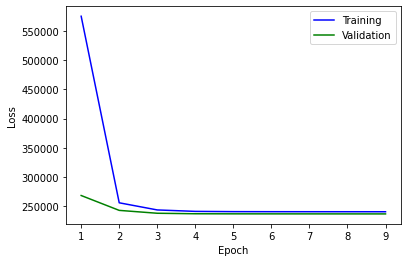

.......................Preprocessing for cluster 1 starts here................................

NO. of batches in Training datset  for cluster  1 is : 4034
NO. of batches in Validation datset for cluster  1 is : 1008
.......................Preprocessing for cluster 1 ends here................................
.......................Training for cluster 1 starts here................................
<bound method Module.parameters of MLP(
  (layers): Sequential(
    (0): Linear(in_features=45, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=1, bias=True)
  )
)>
Train Epoch: 2	 Loss: 288085.564114

Test set: Average loss: 288748.8662

Train Epoch: 4	 Loss: 285338.668947

Test set: Average loss: 288207.3140

Train Epoch: 6	 Loss: 285049.396538

Test set: Average loss: 287937.6193

Train Epoch: 8	 Loss: 284906.073825

Test set: Average loss: 287848.6956

......................

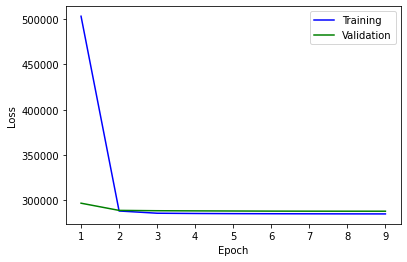

.......................Preprocessing for cluster 2 starts here................................

NO. of batches in Training datset  for cluster  2 is : 7281
NO. of batches in Validation datset for cluster  2 is : 1820
.......................Preprocessing for cluster 2 ends here................................
.......................Training for cluster 2 starts here................................
<bound method Module.parameters of MLP(
  (layers): Sequential(
    (0): Linear(in_features=45, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=1, bias=True)
  )
)>
Train Epoch: 2	 Loss: 292801.692349

Test set: Average loss: 290504.2430

Train Epoch: 4	 Loss: 292620.125066

Test set: Average loss: 290276.3691

Train Epoch: 6	 Loss: 292524.142252

Test set: Average loss: 290143.9566

Train Epoch: 8	 Loss: 292448.252212

Test set: Average loss: 290060.4026

......................

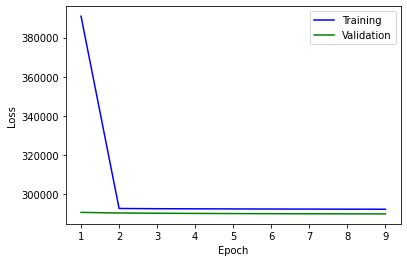

In [ ]:
#Train Model for each cluster by calling above defined functions
epochs=10
space=' '
for  clusterNo in range(0,3):
    avgtrain_loss=[];avgvalidation_loss=[]
    df=pd.read_csv("Cluster_"+str(clusterNo)+".csv",index_col=0)
    df.reset_index(drop=True, inplace=True)
    print(".......................Preprocessing for cluster",clusterNo,"starts here................................")
    train_loader,validation_loader=preprocess(df,clusterNo,True)
    print(".......................Preprocessing for cluster",clusterNo,"ends here................................")
    print(".......................Training for cluster",clusterNo,"starts here................................")
   
    avgtrain_loss,avgvalidation_loss=trainANN(train_loader,validation_loader,epochs,clusterNo,model)
    print(".......................Training for cluster",clusterNo,"ends here................................")
    print(space*25)
    print("...............................Training Loss vs Validation Loss for cluster......................" ,clusterNo)
    plotLoss(avgtrain_loss,avgvalidation_loss,epochs)
   

    

#### Accuracy Metrics of all the Models for each Cluster

In [ ]:
#Accuracy metrics of models developed for Cluster 0
model.cluster0

,modelName,trainScore,testScore,RMSE,MSE,className
0,Basic Multiple Regression,0.683394,0.682891,2748.72,7.555477e+06,MultipleRegression
1,Regression Tree Model,0.64461,0.64461,2922.53,8.541188e+06,RegressorTree
2,Random Forest Regression Model,0.71158,0.702914,2660.53,7.078411e+06,RandomForestRegressor
3,Lasso Regression Model,0.683265,0.68268,2749.64,7.560497e+06,LassoRegression
4,Multi Layer Perceptron,NA,NA,NA,2.370277e+05,MLP


In [ ]:
#Accuracy metrics of models developed for Cluster 1
model.cluster1

,modelName,trainScore,testScore,RMSE,MSE,className
0,Basic Multiple Regression,0.627852,0.622935,3038.85,9.234638e+06,MultipleRegression
1,Regression Tree Model,0.586434,0.586434,3217.61,1.035302e+07,RegressorTree
2,Random Forest Regression Model,0.654313,0.642308,2959.76,8.760178e+06,RandomForestRegressor
3,Lasso Regression Model,0.627696,0.622703,3039.79,9.240327e+06,LassoRegression
4,Multi Layer Perceptron,NA,NA,NA,2.878398e+05,MLP


In [ ]:
#Accuracy metrics of models developed for Cluster 2
model.cluster2

,modelName,trainScore,testScore,RMSE,MSE,className
0,Basic Multiple Regression,0.619709,0.621124,3045.14,9.272883e+06,MultipleRegression
1,Regression Tree Model,0.57693,0.57693,3214.46,1.033273e+07,RegressorTree
2,Random Forest Regression Model,0.646504,0.640373,2966.78,8.801778e+06,RandomForestRegressor
3,Lasso Regression Model,0.619547,0.620923,3045.95,9.277796e+06,LassoRegression
4,Multi Layer Perceptron,NA,NA,NA,2.900269e+05,MLP


Define new accuracy function and calculate average accuracy per cluster. For each prediction We will calculate 1-abs(Prediction-Original)/Original to observe how accuractely the model is predicting.

In [39]:
def calculateAccuracy(accuracyList):
  for  clusterNo in range(0,3):
    df=pd.read_csv("Cluster_"+str(clusterNo)+".csv",index_col=0)
    df.reset_index(drop=True, inplace=True)
    print(".......................Preprocessing for cluster",clusterNo,"starts here................................")
    xValid,yValid=preprocess(df,clusterNo,False)
    modelName='MLP_cluster'+str(clusterNo)+'.pt'
    print("modelName is",modelName)
    model=torch.load(modelName)
    with torch.no_grad():
      predictions=model(xValid)
      tempdf=pd.DataFrame(predictions.numpy(),columns=["prediction"])
      tempdf['original']=yValid.numpy()
      tempdf['accuracy']=round((1- abs(tempdf['prediction']-tempdf['original'])/tempdf['original'])*100,2)
      print("......................Cluster "+str(clusterNo) +" prediction starts here.................")
      print(tempdf.head())
      print("Average Accuracy for cluster "+str(clusterNo) +"is : " ,round(tempdf['accuracy'].mean(),2) ,"%")
      accuracyList.append(round(tempdf['accuracy'].mean(),2))
      print("......................Cluster "+str(clusterNo) +" prediction  ends starts here.................")
    


In [46]:
accuracyList=[]
calculateAccuracy(accuracyList)
print("\n\n Overall Average accuracy across all the three clusters is " ,round(sum(accuracyList)/len(accuracyList),2),"%")

.......................Preprocessing for cluster 0 starts here................................
modelName is MLP_cluster0.pt
......................Cluster 0 prediction starts here.................
     prediction  original   accuracy
0   7430.804688    8088.0  91.870003
1   6503.877441    8575.0  75.849998
2  14215.417969   15486.0  91.800003
3  14006.206055   12111.0  84.349998
4   7652.674805    7902.0  96.839996
Average Accuracy for cluster 0is :  67.2 %
......................Cluster 0 ends starts here.................
.......................Preprocessing for cluster 1 starts here................................
modelName is MLP_cluster1.pt
......................Cluster 1 prediction starts here.................
     prediction  original   accuracy
0  13522.276367   19252.0  70.239998
1   6637.180176    7132.0  93.059998
2  14665.047852   16620.0  88.239998
3  14299.765625   19094.0  74.889999
4  13496.600586   15198.0  88.809998
Average Accuracy for cluster 1is :  64.16 %
...........

####  Deep Neural Network  is performing far better than any other models when we compare the MSE values. Aong ML Models ,Random Forest looks promising in predicting the accurate purchase amount.

In [ ]:
#Save the Model and check one of the models to predict the purchase amount

In [ ]:
model=torch.load('MLP_cluster2.pt')
temp=[5., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.,0.,0.,0.,0.,0.]

with torch.no_grad():
    print(model(torch.Tensor(temp)))

tensor([5981.5835])
